#### Video Data Process

In [3]:
# change mov file to images
import cv2

def _video_to_img(video_path, img_dir, idx):
    video_path = f"{video_path}/IMG_{idx}.MOV"
    video_capture = cv2.VideoCapture(video_path)
    video_capture.set(cv2.CAP_PROP_FPS, 60)

    saved_frame_name = 0
    while video_capture.isOpened():
        frame_is_read, frame = video_capture.read()

        if frame_is_read:
            cv2.imwrite(f"{img_dir}/{idx}_{str(saved_frame_name)}.jpg", frame)
            saved_frame_name += 1

        else:
            print(f"Video to image for {video_path} is done.")
            break

#### Use YOLO to get Bounding Box of hands

In [1]:
import cv2
from matplotlib import pyplot as plt
from ultralytics import  YOLO
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

In [2]:
img_dir = "datasets/hand/imgs"
results = model(f"{img_dir}/frame0.jpg")



image 1/1 /home/robin/project/1122_CSIE/acupoint/datasets/hand/imgs/frame0.jpg: 640x384 1 person, 70.8ms
Speed: 2.3ms preprocess, 70.8ms inference, 644.8ms postprocess per image at shape (1, 3, 640, 384)


In [7]:
for result in results:
    print(result.names)
    boxes = result.boxes  # 取得 bounding box 座標
    for box in boxes:
        print(box.cls)
        x1, y1, x2, y2 = box.xyxy[0]  # 取得 bounding box 的四個角點座標
        conf = box.conf[0]           # 取得 bounding box 的信心度
        print(f'Hand detected at: ({x1}, {y1}), ({x2}, {y2}) with confidence: {conf}')

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

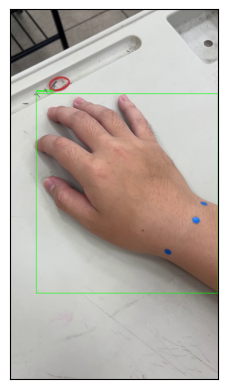

In [9]:
img = cv2.imread(f"{img_dir}/frame0.jpg")
for result in results:
    boxes = result.boxes
    for box in boxes:
        
        if int(box.cls[0]) == 0:
            x1, y1, x2, y2 = box.xyxy[0]
            conf = box.conf[0]
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # 綠色框，粗度 2
            label = f'Hand: {conf:.2f}'
            cv2.putText(img, label, (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            plt.imshow(img[:, :, ::-1], label='Hand Detection')
            plt.xticks([]), plt.yticks([]) 
            plt.show()

In [16]:
import os
import json
def _get_hands_bbox(img_file, idx):
    save_file = f"datasets/hand/labels/{idx}.jsonl"

    # set model
    model = YOLO('yolov8n.yaml')
    model = YOLO('yolov8n.pt')

    results = model(img_file)
    for result in results:
        for box in result.boxes:
            if int(box.cls[0]) == 0:
                x1, y1, x2, y2 = box.xyxy[0]
                conf = box.conf[0]
                label = f'Hand: {conf:.2f}'
                j_file = {
                    'image': img_file,
                    'x1': x1.item(),
                    'x2': x2.item(),
                    'y1': y1.item(),
                    'y2': y2.item(),
                    'confidence': conf.item(),
                }

                with open(save_file, 'a') as f:
                    f.write(json.dumps(j_file) + '\n')

In [32]:
def _crop_img(img_file, label_file):
    with open(label_file, 'r') as f:
        for line in f:
            j_file = json.loads(line)

            img = cv2.imread(j_file['image'])
            x1, x2, y1, y2 = j_file['x1'], j_file['x2'], j_file['y1'], j_file['y2']
            crop_img = img[int(y1):int(y2), int(x1):int(x2)]

            cv2.imwrite(f"datasets/hand/cropped_imgs/{os.path.basename(j_file['image']).split('.jpg')[0]}_cropped.jpg", crop_img)

In [34]:
video_idx = [_ for _ in range(3115, 3121)]
import argparse

def main(args):
    for idx in range(args.video_st_idx, args.video_ed_idx):
        _video_to_img(args.video_dir, args.img_dir, idx)
        for img in os.listdir(args.img_dir):
            _get_hands_bbox(f"{args.img_dir}/{img}")
            _crop_img(f"{args.img_dir}/{img}", f'datasets/hand/{idx}_labels.jsonl')
            
        
        break

    return 0

if __name__ == '__main__':
    argparse = argparse.ArgumentParser()
    argparse.add_argument('--video_st_idx', type=int, required=True, help='start index')
    argparse.add_argument('--video_ed_idx', type=int, required=True, help='end index')
    argparse.add_argument('--video_dir', type=str, default='datasets/hands', required=True, help='video directory')
    argparse.add_argument('--img_dir', type=str, default='datasets/hand/imgs', required=True, help='output image directory')
    argparse.add_argument('--crop_output', type=str, default='datasets/hand/cropped_imgs', required=True, help='output cropped image directory')
    args = argparse.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] --video_st_idx VIDEO_ST_IDX --video_ed_idx
                             VIDEO_ED_IDX --video_dir VIDEO_DIR --img_dir
                             IMG_DIR --crop_output CROP_OUTPUT
ipykernel_launcher.py: error: the following arguments are required: --video_st_idx, --video_ed_idx, --video_dir, --img_dir, --crop_output


SystemExit: 2

/home/robin/project/1122_CSIE/acupoint/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
